## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [2]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
from keras.layers import Dense, Input, BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=n_units, activation='relu', name='hidden_layer%d'%(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = Dense(units=n_units, activation='relu', name='hidden_layer%d'%(i+1))(x)
            x = BatchNormalization()(x)
            
    out = Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [9]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

reduce_lr_factor = [0.5, 0.7]
reduce_lr_patience = [5, 10]

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
for i in itertools.product(optimizer_set[1:], reduce_lr_factor, reduce_lr_patience):
    print(i)

(<keras.optimizers.Adam object at 0x000000001E0BC0F0>, 0.5, 5)
(<keras.optimizers.Adam object at 0x000000001E0BC0F0>, 0.5, 10)
(<keras.optimizers.Adam object at 0x000000001E0BC0F0>, 0.7, 5)
(<keras.optimizers.Adam object at 0x000000001E0BC0F0>, 0.7, 10)
(<keras.optimizers.RMSprop object at 0x000000001E0DE400>, 0.5, 5)
(<keras.optimizers.RMSprop object at 0x000000001E0DE400>, 0.5, 10)
(<keras.optimizers.RMSprop object at 0x000000001E0DE400>, 0.7, 5)
(<keras.optimizers.RMSprop object at 0x000000001E0DE400>, 0.7, 10)


In [14]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patience) in enumerate(itertools.product(optimizer_set[1:], reduce_lr_factor, reduce_lr_patience)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patience))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = ReduceLROnPlateau(factor = reduce_factor,
                             min_lr=1e-12,
                             monitor='val_loss',
                             patience=reduce_patience,
                             verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

50000/50000 [==============================] - 21s 428us/step - loss: 1.1406 - accuracy: 0.6012 - val_loss: 1.4477 - val_accuracy: 0.4814
Epoch 8/25
50000/50000 [==============================] - 21s 426us/step - loss: 1.0910 - accuracy: 0.6208 - val_loss: 1.4283 - val_accuracy: 0.4893
Epoch 9/25
50000/50000 [==============================] - 22s 434us/step - loss: 1.0541 - accuracy: 0.6329 - val_loss: 1.4555 - val_accuracy: 0.4914
Epoch 10/25
50000/50000 [==============================] - 23s 454us/step - loss: 1.0135 - accuracy: 0.6492 - val_loss: 1.4313 - val_accuracy: 0.4945
Epoch 11/25
50000/50000 [==============================] - 21s 424us/step - loss: 0.9751 - accuracy: 0.6639 - val_loss: 1.5193 - val_accuracy: 0.4735
Epoch 12/25
50000/50000 [==============================] - 21s 424us/step - loss: 0.9392 - accuracy: 0.6782 - val_loss: 1.4880 - val_accuracy: 0.4838
Epoch 13/25
50000/50000 [==============================] - 21s 422us/step - loss: 0.9066 - accuracy: 0.6879 - val_

50000/50000 [==============================] - 26s 515us/step - loss: 0.7190 - accuracy: 0.7707 - val_loss: 1.4484 - val_accuracy: 0.5085
Numbers of exp: 3, reduce_factor: 0.70, reduce_patient: 10
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
____________________________________________________________

Epoch 9/25
50000/50000 [==============================] - 21s 427us/step - loss: 1.0709 - accuracy: 0.6246 - val_loss: 1.6066 - val_accuracy: 0.4413
Epoch 10/25
50000/50000 [==============================] - 21s 419us/step - loss: 1.0304 - accuracy: 0.6396 - val_loss: 1.8368 - val_accuracy: 0.3845
Epoch 11/25
50000/50000 [==============================] - 21s 427us/step - loss: 0.9880 - accuracy: 0.6526 - val_loss: 1.6074 - val_accuracy: 0.4498
Epoch 12/25
50000/50000 [==============================] - 21s 427us/step - loss: 0.9514 - accuracy: 0.6643 - val_loss: 2.0201 - val_accuracy: 0.3938
Epoch 13/25
50000/50000 [==============================] - 21s 430us/step - loss: 0.9192 - accuracy: 0.6764 - val_loss: 2.0739 - val_accuracy: 0.3984
Epoch 14/25
50000/50000 [==============================] - 21s 424us/step - loss: 0.8869 - accuracy: 0.6890 - val_loss: 1.7429 - val_accuracy: 0.4330

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 15/25
50000/50

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 23s 455us/step - loss: 1.9784 - accuracy: 0.3288 - val_loss: 2.1188 - val_accuracy: 0.2565
Epoch 2/25
50000/50000 [==============================] - 21s 422us/step - loss: 1.6495 - accuracy: 0.4245 - val_loss: 1.9544 - val_accuracy: 0.3480
Epoch 3/25
50000/50000 [==============================] - 21s 421us/step - loss: 1.5354 - accuracy: 0.4619 - val_loss: 1.8156 - val_accuracy: 0.3808
Epoch 4/25
50000/50000 [==============================] - 21s 427us/step - loss: 1.4561 - accuracy: 0.4897 - val_loss: 1.6874 - val_accuracy: 0.4148
Epoch 5/25
50000/50000 [==============================] - 22s 436us/step - loss: 1.3977 - accuracy: 0.5098 - val_loss: 1.6874 - val_accuracy: 0.4014
Epoch 6/25
50000/50000 [==============================] - 21s 428us/step - loss: 1.3439 - accuracy: 0.5321 - val_loss: 1.5891 - val_accuracy: 0.4401
Epoch 7/25
50000/50000 [==============================] 

Epoch 20/25
50000/50000 [==============================] - 22s 432us/step - loss: 1.0159 - accuracy: 0.6530 - val_loss: 1.5126 - val_accuracy: 0.4769
Epoch 21/25
50000/50000 [==============================] - 21s 423us/step - loss: 0.9918 - accuracy: 0.6644 - val_loss: 1.5164 - val_accuracy: 0.4734
Epoch 22/25
50000/50000 [==============================] - 21s 417us/step - loss: 0.9754 - accuracy: 0.6700 - val_loss: 1.4777 - val_accuracy: 0.4883
Epoch 23/25
50000/50000 [==============================] - 23s 452us/step - loss: 0.9552 - accuracy: 0.6780 - val_loss: 1.6153 - val_accuracy: 0.4468
Epoch 24/25
50000/50000 [==============================] - 22s 431us/step - loss: 0.9382 - accuracy: 0.6837 - val_loss: 1.5281 - val_accuracy: 0.4789
Epoch 25/25
50000/50000 [==============================] - 21s 420us/step - loss: 0.9211 - accuracy: 0.6910 - val_loss: 1.5498 - val_accuracy: 0.4783


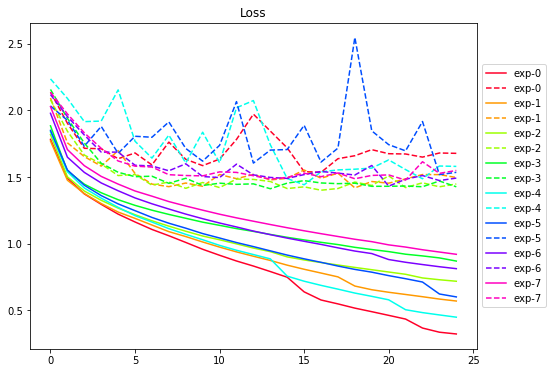

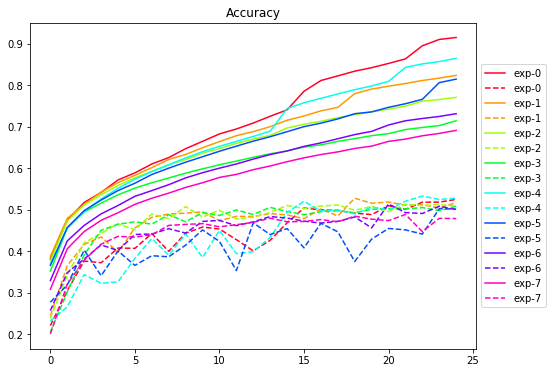

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()